# Notebook Description

In this notebook, we will be creating and training a deep neural network to distinguish betweeen 5 classes of animals. These animals are

- Cows
- Dogs
- Dolphins
- Foxes
- Starfishes

The images of these animals are procured from    
https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals.

# Loading Dataset from Kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle ; mv kaggle.json ~/.kaggle ; chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals

 98% 642M/656M [00:07<00:00, 115MB/s]
100% 656M/656M [00:07<00:00, 88.5MB/s]


In [ ]:
! mv animal-image-dataset-90-different-animals.zip all-animals.zip
! unzip all-animals

In [ ]:
! mkdir Animals
! mv -t Animals animals/animals/cow animals/animals/dog animals/animals/dolphin \
animals/animals/fox animals/animals/starfish

In [ ]:
! rm -rf animals all-animals.zip name\ of\ the\ animals.txt

# Importing Libraries

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import splitfolders
import numpy as np
import warnings
import absl.logging

from pathlib import Path
from PIL import Image

from tensorflow.keras.utils import image_dataset_from_directory

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# Exploratory Data Analysis

We will first examine the total number of images for each class and then plot some images.

In [ ]:
path = Path("./Animals")

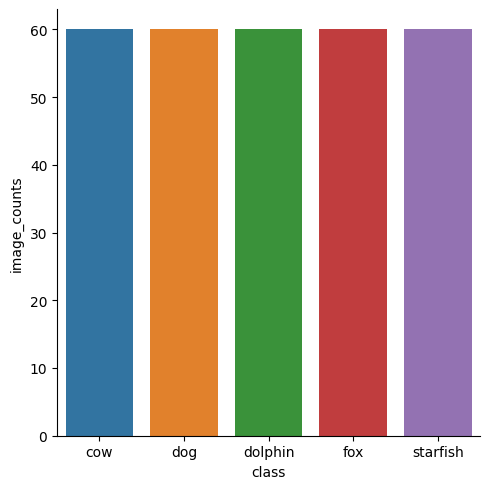

In [ ]:
# analyse the total number of images in each class
class_names = []
img_counts = []

for child in sorted(path.iterdir()):
  class_name = child.name
  total_images = len(sorted(child.glob("*.jpg")))
  class_names.append(class_name)
  img_counts.append(total_images)

df = pd.DataFrame({"class": class_names, "image_counts": img_counts })

sns.catplot(data=df, x="class", y="image_counts", kind="bar")

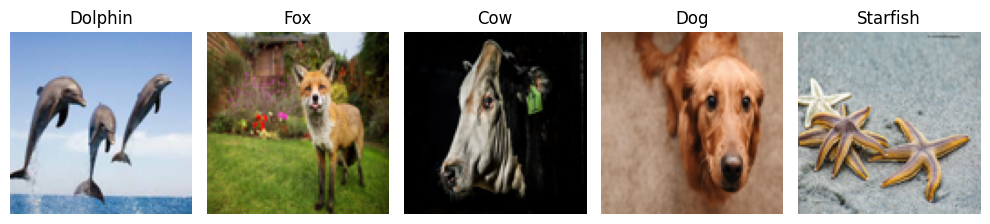

In [ ]:
# plotting a random image from each class
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10, 10))
col = 0

for child in path.iterdir():
  class_name = child.name.capitalize()
  all_child_imgs = sorted(child.glob("*.jpg"))
  selections = np.random.choice(all_child_imgs, size=1, replace=False)
  for img_path in selections:
    image = Image.open(img_path)
    image = image.resize((100, 100))
    position = axes[col]
    position.imshow(image)
    position.grid(None)
    position.axis('off')
    position.set_title(class_name)
    col += 1

fig.tight_layout()

# Creating Datasets

The split for the Training /Validation/ Testing dataset will be 0.70 / 0.15 / 0.15

In [ ]:
# creating the train / validation / test subdirectories
splitfolders.ratio(path, output="datasets", ratio=(.7, .15, .15))

Copying files: 300 files [00:00, 1935.53 files/s]


In [ ]:
# creating datasets
train_dataset = image_dataset_from_directory("datasets/train", 
                                             image_size=(64, 64), batch_size=15)
val_dataset = image_dataset_from_directory("datasets/val", 
                                           image_size=(64, 64), batch_size=15)
test_dataset = image_dataset_from_directory("datasets/test", 
                                            image_size=(64, 64), batch_size=15)

Found 210 files belonging to 5 classes.
Found 45 files belonging to 5 classes.
Found 45 files belonging to 5 classes.


In [ ]:
# IO caching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Creating Model with Sequential API

In this model, we will be using preprocessing layers to ensure our images are scaled to the correct size.

Additionally, random flips and rotations will be introduced as our dataset is small, thereby increasing the number of training examples and prevent overfitting.

Dropout layers and BatchNormalization layers are also introduced to further prevent overfitting.

In [ ]:
from tensorflow.keras import Sequential

from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, MaxPool2D, Resizing, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback, ModelCheckpoint

In [ ]:
def create_model():
  model = Sequential([
      Resizing(64, 64, input_shape=(64, 64, 3)),
      Rescaling(1./255),
      RandomFlip(),
      RandomRotation(0.3),
      Conv2D(32, (3, 3), activation='relu', padding='same'),
      Dropout(0.2),
      MaxPool2D(padding='same'),
      Conv2D(64, (3, 3), activation='relu', padding='same'),
      Dropout(0.2),
      MaxPool2D(padding='same'),
      BatchNormalization(),
      Flatten(),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(32, activation='relu'),
      Dense(5, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['acc'])

  return model

In [ ]:
base_model = create_model()

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                        

## Callbacks

Callbacks are introduced to ensure that the model does not overfit

In [ ]:
epoch_begin = lambda epoch, logs: print(f"Epoch {epoch} done") if epoch % 5 == 0 else None
train_end = lambda logs: print(f"Training finished with validation accuracy of {logs['val_acc']}")

early = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.05, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
debugger = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_train_end=train_end)
checkpoint = ModelCheckpoint(filepath='./base_model_dir/{epoch:02d}',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
history = base_model.fit(train_dataset, epochs=100, verbose=0, 
                         validation_data=val_dataset,
                         callbacks=[early, lr_reduce, debugger, checkpoint])

Epoch 0 done
Epoch 5 done
Epoch 10 done
Epoch 12: early stopping
Training finished with validation accuracy of 0.4000000059604645


<Axes: >

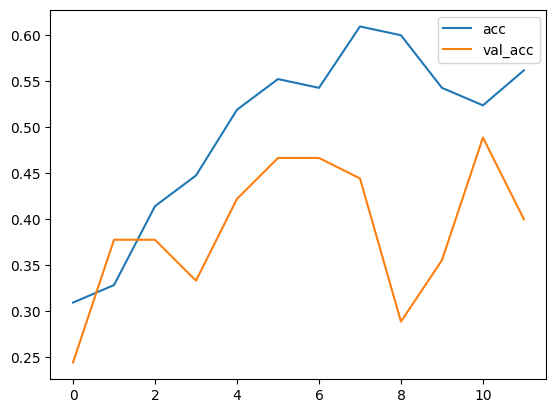

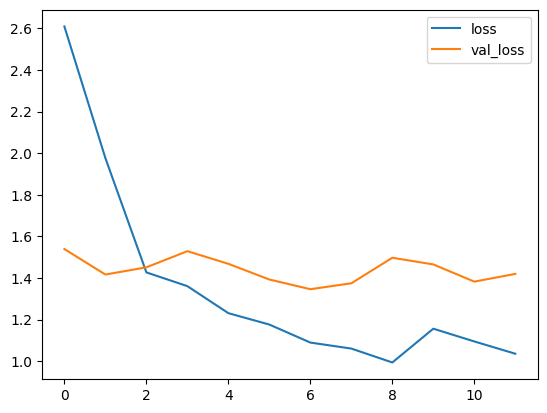

In [ ]:
base_model_history = pd.DataFrame(history.history)

base_model_history.plot(y=['acc', 'val_acc'])
base_model_history.plot(y=['loss', 'val_loss'])

In [ ]:
base_model.evaluate(test_dataset, verbose=1)

3/3 [==============================] - 0s 28ms/step - loss: 1.4781 - acc: 0.2889


[1.4780635833740234, 0.2888889014720917]

# Confusion Matrix

We will visualize the predictions by the model on the test dataset of 45 images

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(base_model.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

3/3 [==============================] - 0s 27ms/step


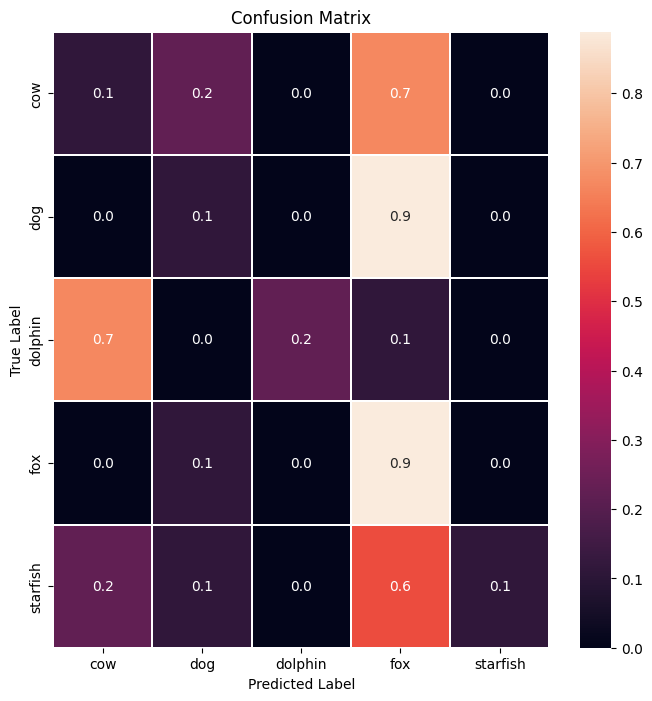

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true')

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01, linecolor='white',
            fmt='.1f', ax=ax)

sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(y_true, y_pred, target_names=class_names, output_dict=True);

df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
cow,0.111111,0.111111,0.111111,9.000000
dog,0.200000,0.111111,0.142857,9.000000
dolphin,1.000000,0.222222,0.363636,9.000000
fox,0.285714,0.888889,0.432432,9.000000
starfish,1.000000,0.111111,0.200000,9.000000
accuracy,0.288889,0.288889,0.288889,0.288889
macro avg,0.519365,0.288889,0.250007,45.000000
weighted avg,0.519365,0.288889,0.250007,45.000000


# Hyperparameter tuning

Using Keras Tuner, we will further fine tune the model

In [ ]:
! pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def model_tuning_builder(hp):
  # tuning first Conv2D layer and kernel
  hp_conv1_units = hp.Int('conv1_units', min_value=32, max_value=64, step=32)
  hp_conv1_kernel = hp.Choice('conv1_kernel', values=[3, 4, 5])

  # tuning second Conv2D layer
  hp_conv2_units = hp.Int('conv2_units', min_value=32, max_value=64, step=32)

  # tuning first Dense layer
  hp_dense_units = hp.Int('dense1_units', min_value=32, max_value=64, step=32)

  model = Sequential([
      Resizing(64, 64, input_shape=(64, 64, 3)),
      Rescaling(1./255),
      RandomFlip(),
      RandomRotation(0.3),
      Conv2D(hp_conv1_units, hp_conv1_kernel, activation='relu', padding='same'),
      Dropout(0.2),
      MaxPool2D(padding='same'),
      Conv2D(hp_conv2_units, (3, 3), activation='relu', padding='same'),
      Dropout(0.2),
      MaxPool2D(padding='same'),
      BatchNormalization(),
      Flatten(),
      Dense(hp_dense_units, activation='relu'),
      Dropout(0.2),
      Dense(32, activation='relu'),
      Dense(5, activation='softmax')
  ])

  # tuning learning rate for optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='sparse_categorical_crossentropy', metrics=['acc'])

  return model

In [ ]:
tuner = kt.Hyperband(model_tuning_builder, objective='val_acc',
                     max_epochs=100, factor=3,
                     directory='tuning_dir', project_name='tuner')

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.05, verbose=1)

In [ ]:
tuner.search(train_dataset, epochs=50, callbacks=[early], validation_data=val_dataset)

Trial 46 Complete [00h 00m 10s]
val_acc: 0.2666666805744171

Best val_acc So Far: 0.5111111402511597
Total elapsed time: 00h 07m 40s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, 
                    callbacks=[debugger], verbose=0)

Epoch 0 done
Epoch 5 done
Epoch 10 done
Epoch 15 done
Epoch 20 done
Epoch 25 done
Epoch 30 done
Epoch 35 done
Epoch 40 done
Epoch 45 done
Training finished with validation accuracy of 0.46666666865348816


In [ ]:
val_acc_per_epoch = history.history['val_acc']
best_epochs = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print(f"Best epoch is {best_epochs}")

Best epoch is 48


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(train_dataset, epochs=best_epochs, validation_data=val_dataset)

Epoch 1/48
14/14 [==============================] - 5s 266ms/step - loss: 2.5756 - acc: 0.2762 - val_loss: 1.5895 - val_acc: 0.1556
Epoch 2/48
14/14 [==============================] - 2s 141ms/step - loss: 1.4589 - acc: 0.3762 - val_loss: 1.5618 - val_acc: 0.2444
Epoch 3/48
14/14 [==============================] - 2s 148ms/step - loss: 1.2887 - acc: 0.4619 - val_loss: 1.5252 - val_acc: 0.3556
Epoch 4/48
14/14 [==============================] - 2s 143ms/step - loss: 1.1707 - acc: 0.5238 - val_loss: 1.5213 - val_acc: 0.4889
Epoch 5/48
14/14 [==============================] - 3s 193ms/step - loss: 1.1033 - acc: 0.5381 - val_loss: 1.4872 - val_acc: 0.4667
Epoch 6/48
14/14 [==============================] - 3s 193ms/step - loss: 0.9829 - acc: 0.6143 - val_loss: 1.4748 - val_acc: 0.3556
Epoch 7/48
14/14 [==============================] - 2s 148ms/step - loss: 1.0474 - acc: 0.5714 - val_loss: 1.4352 - val_acc: 0.5333
Epoch 8/48
14/14 [==============================] - 2s 148ms/step - loss: 0.

In [ ]:
hypermodel.evaluate(test_dataset)

3/3 [==============================] - 0s 31ms/step - loss: 2.2383 - acc: 0.5111


[2.2382943630218506, 0.5111111402511597]

3/3 [==============================] - 0s 30ms/step


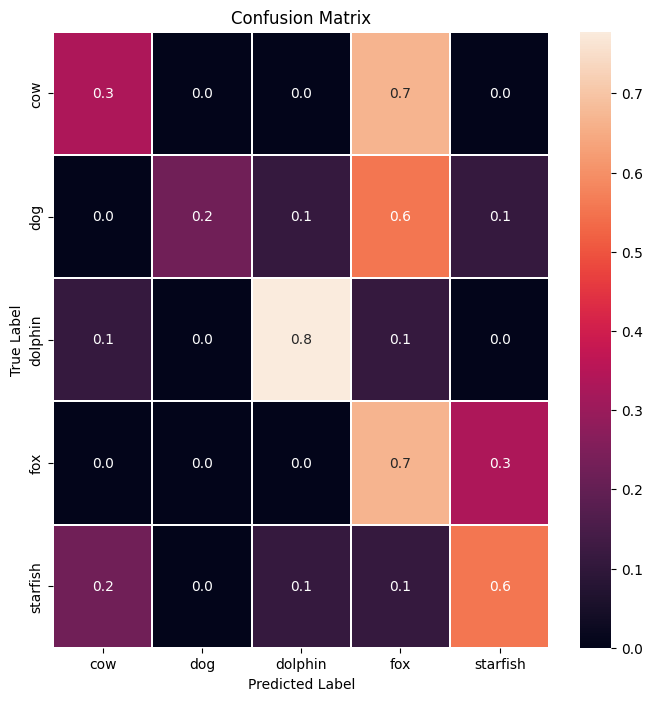

In [ ]:
y_pred_tuned = np.argmax(hypermodel.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

f, ax = plt.subplots(figsize=(8, 8))

confusion_mtx = confusion_matrix(y_true, y_pred_tuned, normalize='true')

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01, linecolor='white',
            fmt='.1f', ax=ax)

sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()

# Transfer Learning

Using the ImageNet model, we will train the model and finetune it further

In [ ]:
! pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

# Try out the model first

model = Sequential([  
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5")
])

model.build([None, 224, 224, 3])

In [ ]:
# Creating a dataset with image size according to the model specification
test_dataset = image_dataset_from_directory("datasets/test", 
                                            image_size=(224, 224), batch_size=15)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Making predictions 
predictions = model.predict(test_dataset)

Found 45 files belonging to 5 classes.
3/3 [==============================] - 2s 395ms/step


In [ ]:
# Retrieve the mappings
labels_path = tf.keras.utils.get_file("ImageNetLabels.txt","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")

imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


In [ ]:
imagenet_labels[tf.math.argmax(predictions, axis=1)][:5]

array(['shower curtain', 'shower curtain', 'shower curtain',
       'window screen', 'shower curtain'], dtype='<U30')

It appears that certain labels are always being predicted, which could be a good sign that the labels are consistently being predicted correctly. We will now extract only the feature vectors and reduce the model to only our 5 classes.

In [ ]:
imagenet = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feature_vector = hub.KerasLayer(imagenet, trainable=False, input_shape=(224, 224, 3))

In [ ]:
# Creating Datasets
train_dataset = image_dataset_from_directory("datasets/train", 
                                             image_size=(224, 224), batch_size=15)
val_dataset = image_dataset_from_directory("datasets/val", 
                                           image_size=(224, 224), batch_size=15)
test_dataset = image_dataset_from_directory("datasets/test", 
                                            image_size=(224, 224), batch_size=15)

# IO
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 210 files belonging to 5 classes.
Found 45 files belonging to 5 classes.
Found 45 files belonging to 5 classes.


In [ ]:
from tensorflow.keras import Input, Model

inputs = Input(shape=(224, 224, 3))
h = Rescaling(1./255)(inputs)
h = feature_vector(h)
h = Dense(64, activation='relu')(h)
h = Dense(5, activation='softmax')(h)
model = Model(inputs=inputs, outputs=h)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
Total params: 2,340,293
Trainable params: 82,309
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Callbacks
early = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.05, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath='./transfer_model_dir/{epoch:02d}',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset,
                    callbacks=[early, lr_reduce, checkpoint])

Epoch 1/30
14/14 [==============================] - 37s 2s/step - loss: 0.8567 - acc: 0.7190 - val_loss: 0.1456 - val_acc: 0.9778 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - 20s 1s/step - loss: 0.0550 - acc: 0.9905 - val_loss: 0.0483 - val_acc: 0.9778 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - 14s 1s/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9778 - lr: 0.0010
Epoch 4/30
14/14 [==============================] - 16s 1s/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9778 - lr: 0.0010
Epoch 5/30
14/14 [==============================] - 15s 1s/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9778 - lr: 0.0010
Epoch 6/30
14/14 [==============================] - 17s 1s/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9778 - lr: 0.0010
Epoch 7/30
14/14 [==============================] - 15s 1s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9778 - lr: 0.0010

<Axes: >

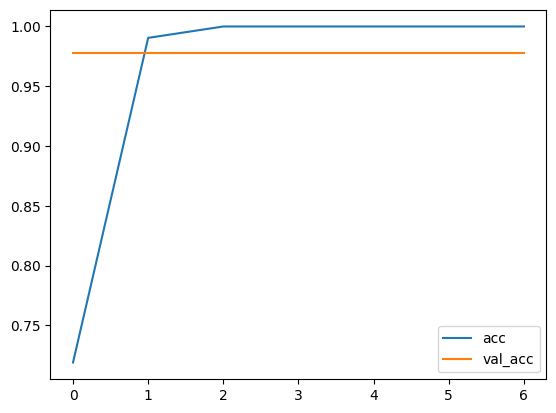

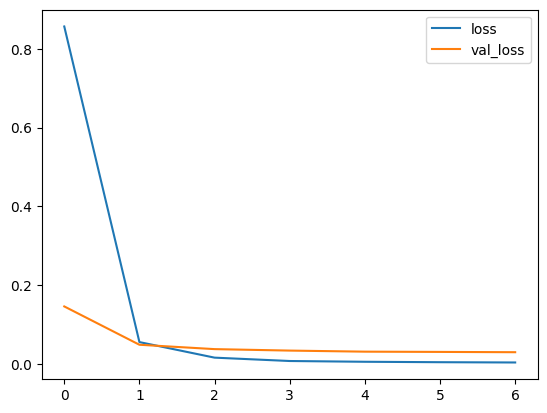

In [ ]:
transfer_model_history = pd.DataFrame(history.history)

transfer_model_history.plot(y=['acc', 'val_acc'])
transfer_model_history.plot(y=['loss', 'val_loss'])

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 401ms/step - loss: 0.0522 - acc: 0.9778


[0.05221307650208473, 0.9777777791023254]

3/3 [==============================] - 2s 420ms/step


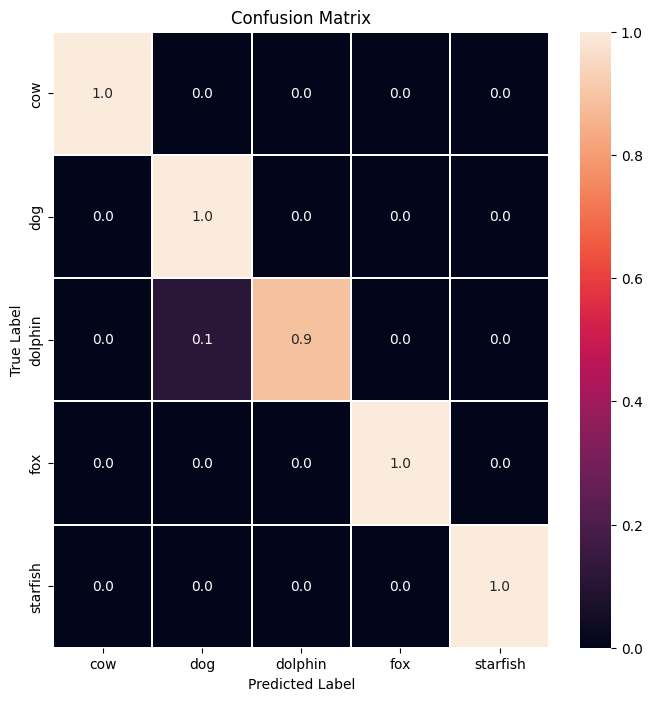

In [ ]:
y_pred_tuned = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

f, ax = plt.subplots(figsize=(8, 8))

confusion_mtx = confusion_matrix(y_true, y_pred_tuned, normalize='true')

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01, linecolor='white',
            fmt='.1f', ax=ax)

sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()

Overall, we observe that using transfer learning, there is a marked improvement in the classification accuracy of our classifier

# Fine Tuning
As a final addition, we will fine tune our model for even better performance

In [ ]:
model.layers

In [ ]:
model.layers[1].trainable=True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# Callbacks
early = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.05, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath='./fine_tune_model_dir/{epoch:02d}',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
fine_tuned_history = model.fit(train_dataset, epochs=30, 
                               validation_data=val_dataset, 
                               callbacks=[early, lr_reduce, checkpoint])

Epoch 1/30
14/14 [==============================] - 17s 1s/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0287 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 2/30
14/14 [==============================] - 15s 1s/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 3/30
14/14 [==============================] - 16s 1s/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 4/30
14/14 [==============================] - 16s 1s/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 5/30
14/14 [==============================] - 16s 1s/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 6/30
14/14 [==============================] - 15s 1s/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9778 - lr: 1.0000e-05
Epoch 6: early stopping


In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 395ms/step - loss: 0.0501 - acc: 0.9778


[0.05014554038643837, 0.9777777791023254]

3/3 [==============================] - 2s 389ms/step


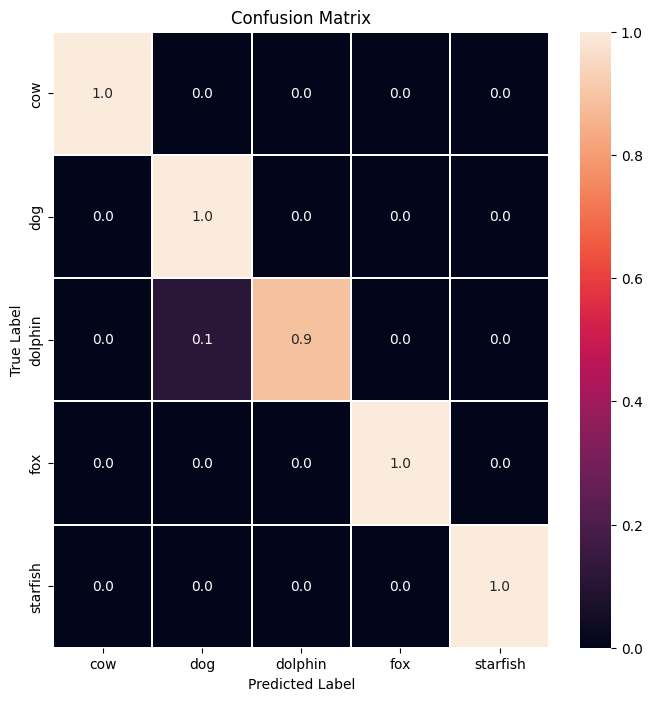

In [ ]:
y_pred_tuned = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

f, ax = plt.subplots(figsize=(8, 8))

confusion_mtx = confusion_matrix(y_true, y_pred_tuned, normalize='true')

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01, linecolor='white',
            fmt='.1f', ax=ax)

sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()

<Axes: >

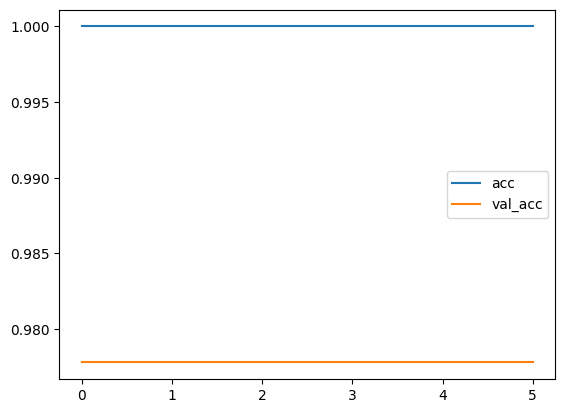

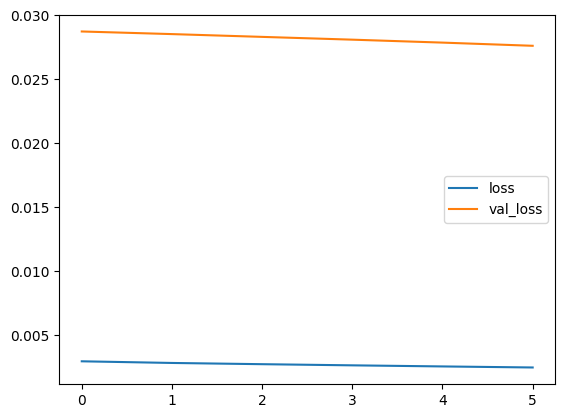

In [ ]:
fine_tuned_model_history = pd.DataFrame(fine_tuned_history.history)

fine_tuned_model_history.plot(y=['acc', 'val_acc'])
fine_tuned_model_history.plot(y=['loss', 'val_loss'])

Overall the model performs very well on all categories

This concludes our classification model between
1. Cows
2. Dogs
3. Dolphins
4. Foxes
5. Starfishes 

In [ ]:
# Saving the model for future use

model.save("animal_classification_model")

In [ ]:
# Downloading the model
! zip -r /content/production_model.zip /content/animal_classification_model

files.download('./production_model.zip')

In [ ]:
# Downloading all other content

! zip -r /content/all_items /content/Animals /content/base_model_dir /content/datasets /content/fine_tune_model_dir /content/sample_data /content/transfer_model_dir /content/tuning_dir

In [ ]:
files.download('./all_items.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
a = tf.keras.models.load_model("animal_classification_model")